<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_unbalance_merge_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot

     |████████████████████████████████| 61 kB 19 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Default GPU Device: /device:GPU:0
True
2.8.0
2.8.0


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


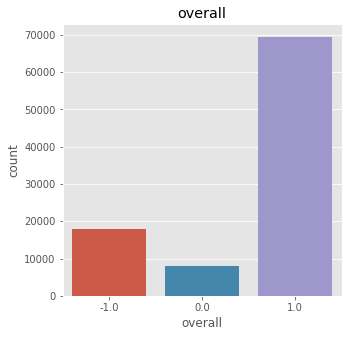

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


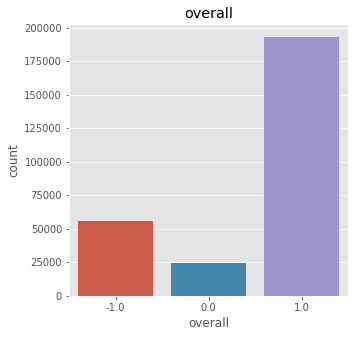

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


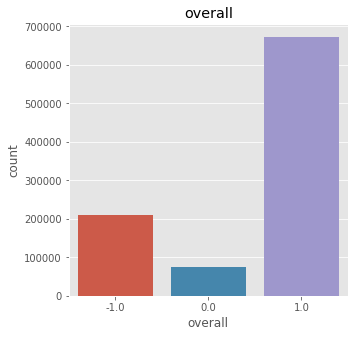

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


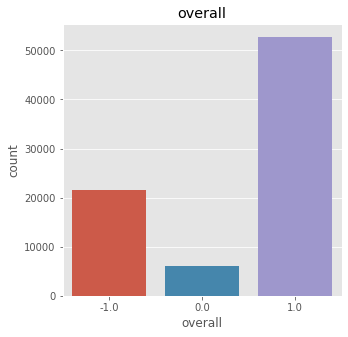

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5000 positive，5000 negative，5000 neutral

80%(12000) training and 20%(3000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4000,:]
  train_neudata = neu.iloc[:4000,:]
  train_negdata = neg.iloc[:4000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4000:5000,:]
  test_neudata = neu.iloc[4000:5000,:]
  test_negdata = neg.iloc[4000:5000,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1997 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df1_test.shape

(3000, 3)

## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [ ]:
df4_test.head()

,overall,reviewTime,reviewText,cleanText
32966,0.0,2018,"I really liked, but it come with the broken fi...",really liked come broken fitting
51809,0.0,2018,If you're looking for the adapter pictured thi...,youre looking adapter pictured product gets jo...
8692,2.0,2018,"Didnt even come in a case, just a sleeve. Grea...",didnt even come case sleeve great gift turned
28001,1.0,2018,My son love to dance all of the songs.,son love dance songs
65968,1.0,2018,We buy most all of the Lego games for Xbox 360...,buy lego games xbox best enjoyed hobbit versio...


## Merge train&test data

In [ ]:
def merge(df1,df2,df3,df4,rate1,rate2):
  sample1 = df1.sample(frac=rate1,replace=False,random_state=None,axis=0) # sample frac rate of rows from the dataframe without replacement
  sample2 = df2.sample(frac=rate2,replace=False,random_state=None,axis=0)
  sample3 = df3.sample(frac=rate2,replace=False,random_state=None,axis=0)
  sample4 = df4.sample(frac=rate2,replace=False,random_state=None,axis=0)

  merged = pd.concat([sample1, sample2, sample3, sample4],sort=False).sample(frac=1.0)

  return merged

In [ ]:
train_merged = merge(df1_train,df2_train,df3_train,df4_train,0.4,0.2)
test_merged = merge(df1_test,df2_test,df3_test,df4_test,0.4,0.2)

In [ ]:
train_merged2 = merge(df1_train,df2_train,df3_train,df4_train,0.7,0.1)
test_merged2 = merge(df1_test,df2_test,df3_test,df4_test,0.7,0.1)

In [ ]:
test_merged.shape

(3000, 4)

In [ ]:
train_merged.shape

(12000, 4)

## Text Tokenization

In [ ]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

47945 words are used
Training:
Average length of each row >> 76.49233333333333
Maximum length of each row >> 1734


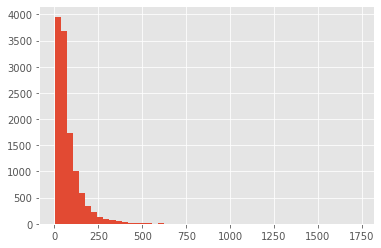

Testing
Average length of each row >> 72.11666666666666
Maximum length of each row >> 879


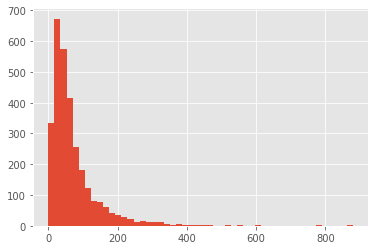

max sequence length:  1734


In [ ]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

35415 words are used
Training:
Average length of each row >> 58.68541666666667
Maximum length of each row >> 3615


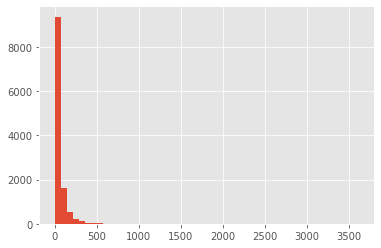

Testing
Average length of each row >> 56.18066666666667
Maximum length of each row >> 835


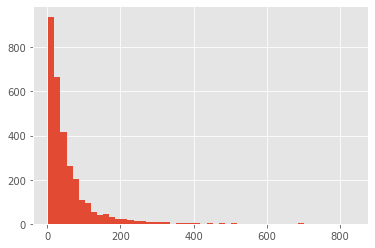

max sequence length:  3615


In [ ]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

19108 words are used
Training:
Average length of each row >> 25.433916666666665
Maximum length of each row >> 841


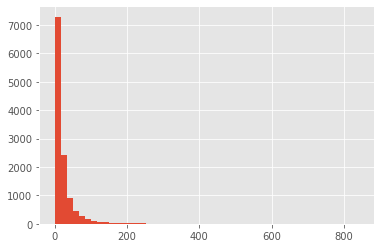

Testing
Average length of each row >> 25.465333333333334
Maximum length of each row >> 1687


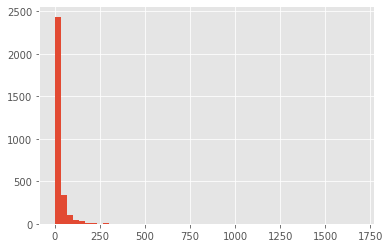

max sequence length:  1687


In [ ]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

14638 words are used
Training:
Average length of each row >> 19.244083333333332
Maximum length of each row >> 463


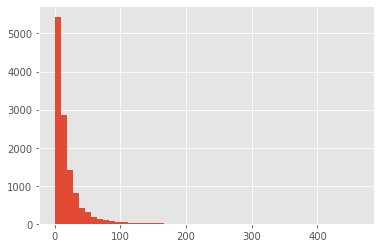

Testing
Average length of each row >> 18.715333333333334
Maximum length of each row >> 395


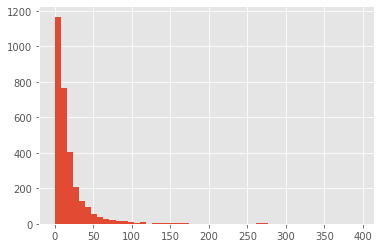

max sequence length:  463


In [ ]:
df4_train_fea,df4_test_fea,df4_vocab_size,df4_maxlen = tokenize(df4_train["cleanText"],df4_test["cleanText"])

35894 words are used
Training:
Average length of each row >> 51.67091666666666
Maximum length of each row >> 1734


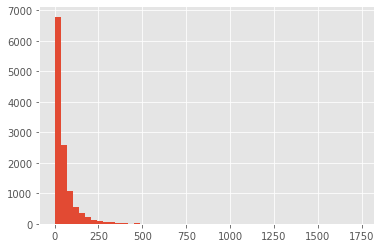

Testing
Average length of each row >> 47.595
Maximum length of each row >> 1724


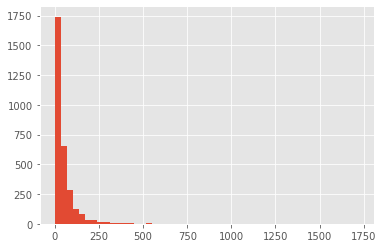

max sequence length:  1734


In [ ]:
merge_train_fea,merge_test_fea,merge_vocab_size,merge_maxlen = tokenize(train_merged["cleanText"],test_merged["cleanText"])

42416 words are used
Training:
Average length of each row >> 63.6425
Maximum length of each row >> 1734


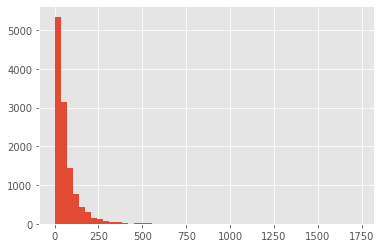

Testing
Average length of each row >> 60.67933333333333
Maximum length of each row >> 876


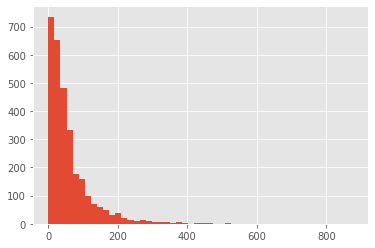

max sequence length:  1734


In [ ]:
merge_train_fea2,merge_test_fea2,merge_vocab_size2,merge_maxlen2 = tokenize(train_merged2["cleanText"],test_merged2["cleanText"])

## Padding

In [ ]:
sequence_size = 400
print("max sequence length for game: ",sequence_size)

max sequence length for game:  400


In [ ]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

df4_train_pad = pad_sequences(df4_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_test_pad = pad_sequences(df4_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_train_label = to_categorical(df4_train.overall,num_classes=3)
df4_test_label = to_categorical(df4_test.overall,num_classes=3)

merge_train_pad = pad_sequences(merge_train_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_test_pad = pad_sequences(merge_test_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_train_label = to_categorical(train_merged.overall,num_classes=3)
merge_test_label = to_categorical(test_merged.overall,num_classes=3)

merge_train_pad2 = pad_sequences(merge_train_fea2,maxlen=sequence_size,padding='post',truncating='post')
merge_test_pad2 = pad_sequences(merge_test_fea2,maxlen=sequence_size,padding='post',truncating='post')
merge_train_label2 = to_categorical(train_merged2.overall,num_classes=3)
merge_test_label2 = to_categorical(test_merged2.overall,num_classes=3)

## Build LSTM Model and Train on merged train (4:2:2:2)

In [ ]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 256
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,df4_vocab_size,merge_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  47945


In [ ]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [ ]:
bilstm = bilstm_model()
plot_model(bilstm)
lstm_no_hist = bilstm.fit(merge_train_pad,merge_train_label,epochs=epochs,batch_size=batch_size,validation_data=(merge_test_pad,merge_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          4794500   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 256)         234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 32)                3276832   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

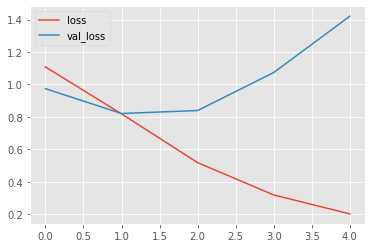

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

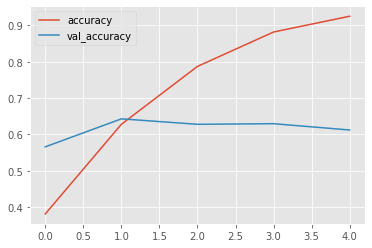

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
bilstm.save('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge_unbalanced.h5')

## Build LSTM Model and Train on merged train (7:1:1:1)

In [ ]:
bilstm2 = bilstm_model()
plot_model(bilstm2)
lstm_no_hist = bilstm2.fit(merge_train_pad2,merge_train_label2,epochs=epochs,batch_size=batch_size,validation_data=(merge_test_pad2,merge_test_label2),callbacks=[es])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 100)          4794500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 400, 256)         234496    
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 102400)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                3276832   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                      

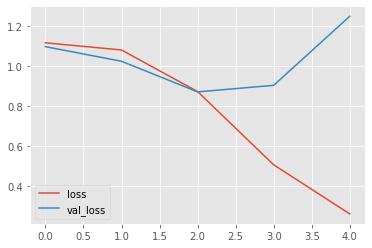

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

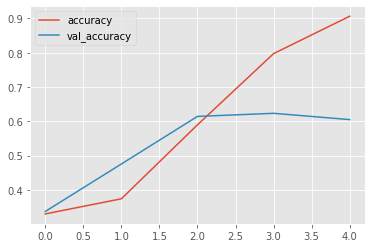

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
bilstm2.save('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge_unbalanced2.h5')

## Evaluate on each time period data

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df1_test_pad,df1_test_label)

94/94 [==============================] - 3s 21ms/step - loss: 3.1916 - accuracy: 0.3453


[3.1916067600250244, 0.3453333377838135]

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df2_test_pad,df2_test_label)

94/94 [==============================] - 3s 22ms/step - loss: 3.0412 - accuracy: 0.3303


[3.0411624908447266, 0.33033332228660583]

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df3_test_pad,df3_test_label)

94/94 [==============================] - 3s 20ms/step - loss: 2.2822 - accuracy: 0.3543


[2.2822065353393555, 0.3543333411216736]

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df4_test_pad,df4_test_label)

94/94 [==============================] - 3s 21ms/step - loss: 2.2285 - accuracy: 0.3407


[2.228511333465576, 0.34066668152809143]

In [ ]:
load_lstm2 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge_unbalanced2.h5')

In [ ]:
load_lstm2.evaluate(df1_test_pad,df1_test_label)

94/94 [==============================] - 3s 20ms/step - loss: 2.3721 - accuracy: 0.3280


[2.372061014175415, 0.328000009059906]

In [ ]:
load_lstm2.evaluate(df2_test_pad,df2_test_label)

94/94 [==============================] - 2s 20ms/step - loss: 2.0998 - accuracy: 0.3560


[2.099752187728882, 0.35600000619888306]

In [ ]:
load_lstm2.evaluate(df3_test_pad,df3_test_label)

94/94 [==============================] - 2s 20ms/step - loss: 1.7295 - accuracy: 0.3553


[1.7295233011245728, 0.3553333282470703]

In [ ]:
load_lstm2.evaluate(df4_test_pad,df4_test_label)

94/94 [==============================] - 2s 21ms/step - loss: 1.6578 - accuracy: 0.3430


[1.6577775478363037, 0.34299999475479126]